In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt
from astropy.stats import LombScargle
import astropy.convolution as cv
plt.style.use('seaborn')
style = {
    'figure.figsize': (12, 8),
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 14,
}
rcParams.update(style)
import os
import pymc3 as pm

In [3]:
# lc = pd.read_table('data/kplr007107778_kasoc-ts_slc_v1.dat', sep='\s+', comment='#', names=['time', 'flux', 'flux_error'], dtype='f8')
psd = pd.read_table('data/kplr007107778_kasoc-psd_slc_v1.pow', sep='\s+', comment='#', names=['freq', 'power'], dtype='f8')

In [4]:
mask = psd['freq'] > 12
full_freq = psd['freq'][mask].values
power = psd['power'][mask].values
fstep = 1
freq = np.arange(min(full_freq), max(full_freq), fstep)
smoothed_power = cv.convolve(power, cv.Box1DKernel(6 / (full_freq[1] - full_freq[0])))
itrp_power = np.interp(freq, full_freq, smoothed_power)
print(itrp_power.shape)

(8485,)


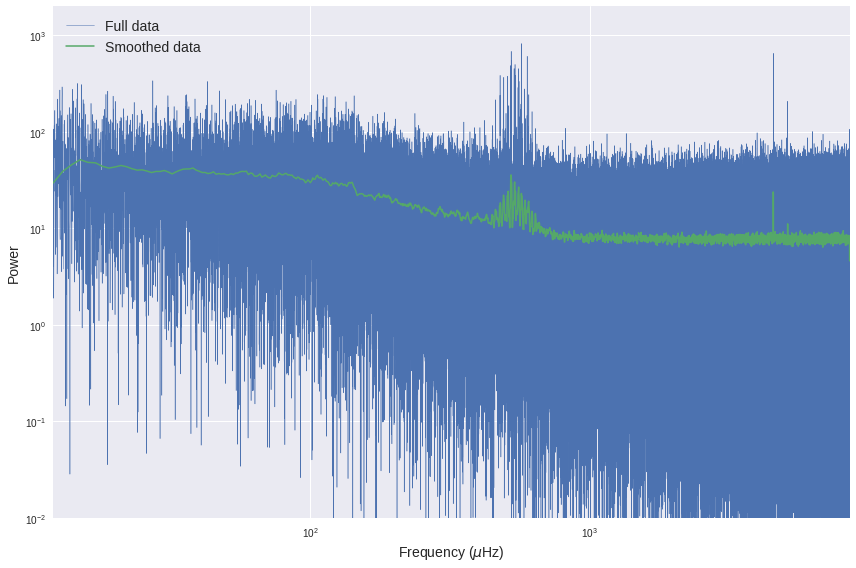

In [5]:
plt.loglog(full_freq, power, lw=.5, alpha=1, c='C0')
plt.loglog(freq, itrp_power, 'C1', lw=1.5)
plt.ylim(1e-2, None)
plt.xlim(min(freq), max(freq))
plt.xlabel(r'Frequency ($\mu$Hz)')
plt.ylabel('Power')
plt.tight_layout();
plt.legend(['Full data', 'Smoothed data'])
# plt.savefig('figs/psd_pre.pdf')

In [19]:
import theano.tensor as tt
from theano.compile.ops import as_op

def response(freq, v_nyq=8496.355743094671):
    theta = np.pi / 2 * freq / v_nyq
    try:
        return pm.math.sin(theta)**2 / theta**2
    except:
        return np.sin(theta)**2 / theta**2
    
def harvey(freq, a, b):
    return 2 * np.sqrt(2) / np.pi * (a**2 / b) / (1 + (freq/b)**4)

def envelope(freq, H0, v_max, s):
    try:
        return H0 * pm.math.exp(-(v_max - freq)**2 / (2*s**2))
    except:
        return H0 * np.exp(-(v_max - freq)**2 / (2*s**2))

def background(freq, W, harvs):
    try:
        return W + response(freq) * pm.math.sum(harvs, axis=0) 
    except:
        return W + response(freq) * np.sum(harvs, axis=0) 

def likelihood(freq, W, harvs, env):
    return background(freq, W, harvs) + response(freq) * env

In [32]:
with pm.Model() as background_model:
        k = BackgroundModel.num_harveys
        
        W = pm.Uniform('W', lower=5, upper=20)
        a = pm.Uniform('a', lower=[30, 40, 50], upper=[86, 96, 105], shape=k)
        b = pm.Uniform('b', lower=[1, 80, 300], upper=[10, 210, 500], shape=k)
        
        harvs = [BackgroundModel.harvey(freq, a[i], b[i]) for i in range(k)]
        
        H0 = pm.Uniform('H0', lower=5, upper=30)
        v_max = pm.Uniform('v_max', lower=500, upper=700)
        s = pm.Uniform('s', lower=20, upper=80)
        
        env = BackgroundModel.envelope(freq, H0, v_max, s)
        like = BackgroundModel.likelihood(freq, W, harvs, env)
        y = pm.Exponential('obs', lam=1/like, observed=power)

In [33]:
with max_model:
    trace = pm.sample(1000, tune=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s, v_max, H0, b, a, W]
Sampling 4 chains: 100%|██████████| 44000/44000 [02:48<00:00, 260.38draws/s]


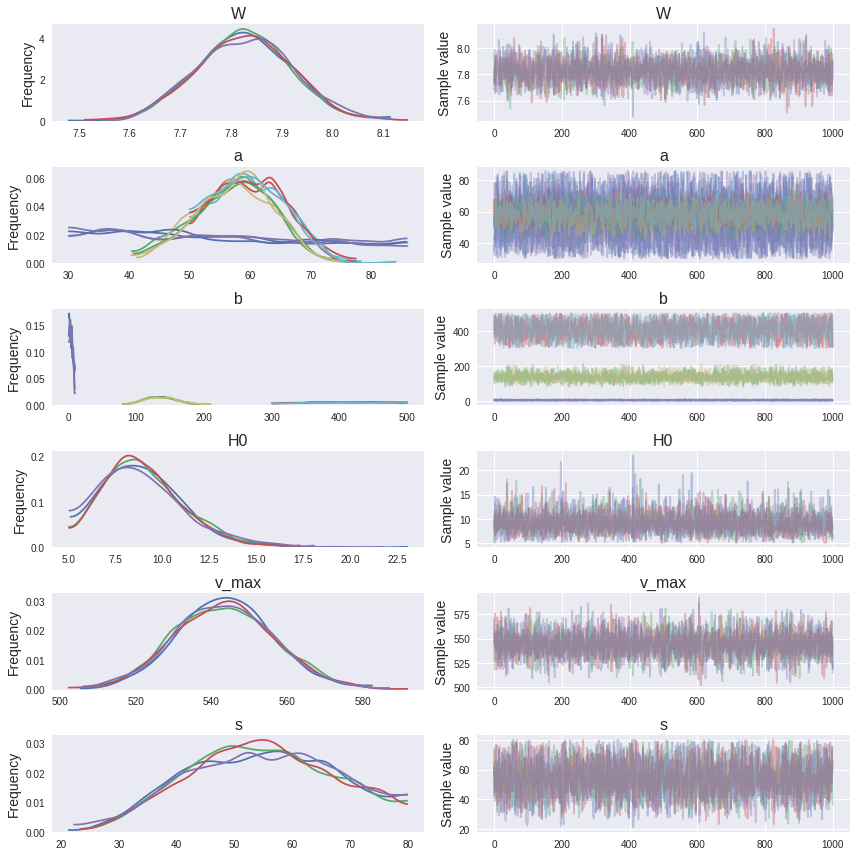

In [34]:
pm.traceplot(trace);
# plt.savefig('figs/trace1.pdf')

In [35]:
summ = pm.summary(trace)
# summ.to_csv('trace_summary.csv')
summ

mean         sd  mc_error     hpd_2.5    hpd_97.5        n_eff  \
W        7.824521   0.092063  0.001650    7.637891    7.991481  3560.031287   
a__0    55.309716  16.063107  0.274640   30.033634   82.564006  3431.135812   
a__1    57.210906   6.539873  0.131311   43.620143   68.482514  2251.979569   
a__2    60.309297   5.747804  0.107976   50.013382   70.169674  2465.807603   
b__0     4.783322   2.390030  0.035701    1.009390    8.981936  3773.076227   
b__1   137.108007  24.696373  0.471453   89.426100  184.071255  2757.842104   
b__2   405.158056  55.506687  1.045759  312.968617  498.726711  2744.952363   
H0       9.011072   2.200689  0.034472    5.216170   13.184348  4086.515363   
v_max  543.321978  13.099323  0.152956  517.675251  569.219264  4601.334829   
s       54.655788  12.536345  0.187847   34.243942   79.952159  3536.054325   

           Rhat  
W      0.999776  
a__0   1.000009  
a__1   1.001034  
a__2   1.000679  
b__0   1.000460  
b__1   1.000027  
b__2   0.999732  
H0     0.999744  
v_max  0.999710  
s      0.999599

In [38]:
ppc = pm.sample_ppc(trace, 10000, max_model)
post = ppc['obs'].mean(axis=0)

100%|██████████| 10000/10000 [00:19<00:00, 500.83it/s]


ValueError: x and y must have same first dimension, but have shapes (8485,) and (3, 8485)

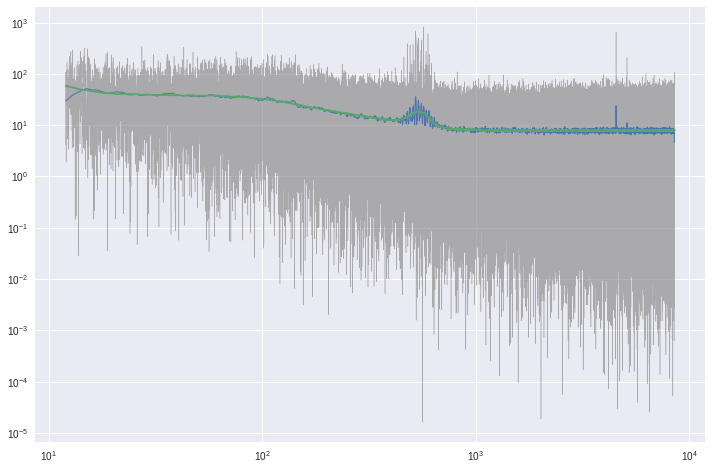

In [42]:
plt.loglog(full_freq, power, lw=.5, alpha=.6, c='.5', label='Full data')
plt.loglog(freq, itrp_power, 'C0', lw=1, label='Smoothed data')
plt.loglog(freq, post, 'C1', label='Fit')
# plt.axvline(trace['v_max'].mean(), c='k', ls='--')
a = trace['a'].mean(axis=0)
b = trace['b'].mean(axis=0)
harveys = [harvey(freq, a[i], b[i]) for i in range(k)]
hls = plt.loglog(freq, harveys, 'C2-.', alpha=.8) 
hls[0][0].set_label('Harvey Profile')
plt.axhline(trace['W'].mean(), c='k', alpha=.3, ls='--', label='White noise')
plt.loglog(freq, background(freq, ))
plt.ylim(1e-2, None)
plt.xlim(min(freq), max(freq))
plt.xlabel(r'Frequency ($\mu$Hz)')
plt.ylabel('Power')
plt.tight_layout()
plt.legend()
# plt.savefig('figs/psd_fit.pdf')

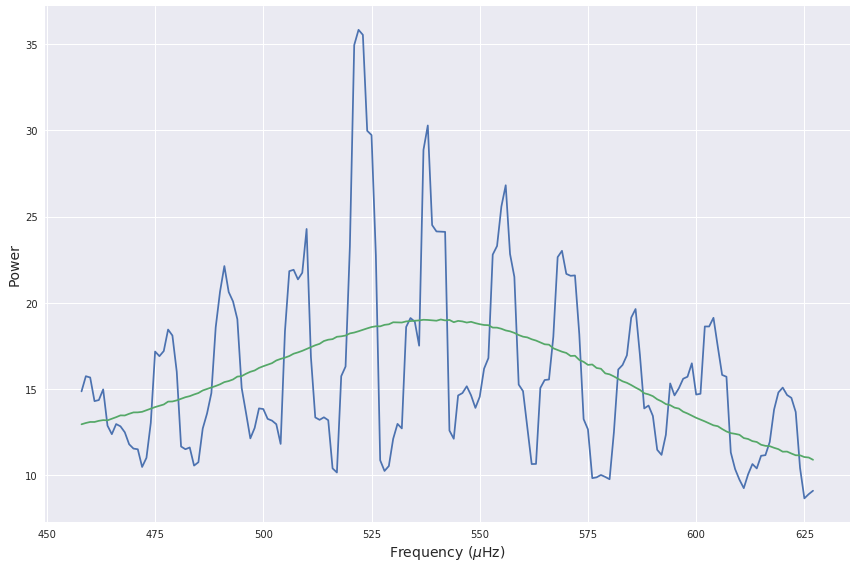

In [134]:
s = trace.get_values('s').mean(axis=0)
v_max = trace.get_values('v_max').mean(axis=0)
mask = (full_freq > (v_max - 2 * s)) & (full_freq < (v_max + 2 * s))
m = (freq > (v_max - 2 * s)) & (freq < (v_max + 2 * s))
subfreq = full_freq[mask]
subpower = power[mask]
plt.plot(freq[m], itrp_power[m])
plt.plot(freq[m], post[m])
plt.xlabel(r'Frequency ($\mu$Hz)')
plt.ylabel('Power')
plt.tight_layout()
plt.legend(['Smoothed data', 'Envelope'])
plt.savefig('figs/env_fit.pdf')

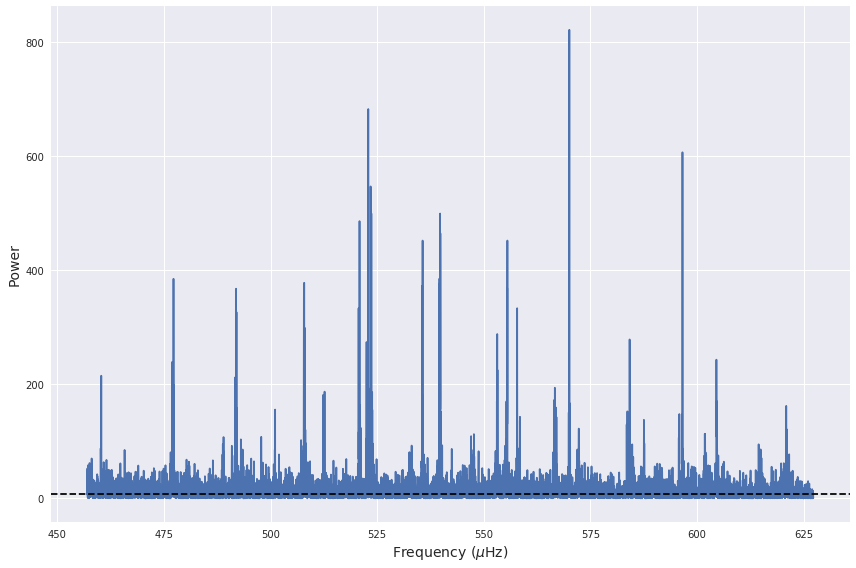

In [136]:
s = trace.get_values('s').mean(axis=0)
v_max = trace.get_values('v_max').mean(axis=0)
mask = (full_freq > (v_max - 2 * s)) & (full_freq < (v_max + 2 * s))
subfreq = full_freq[mask]
subpower = power[mask]
plt.plot(subfreq, subpower)
plt.axhline(trace.get_values('W').mean(), c='k', ls='--')
plt.xlabel(r'Frequency ($\mu$Hz)')
plt.ylabel('Power')
plt.tight_layout()
plt.savefig('figs/env.pdf')

In [93]:
mask = (full_freq > 470) & (full_freq < 485)
ff = full_freq[mask]
pp = power[mask]

fstep = ff[1]-ff[0]
subfreq = np.linspace(min(ff), max(ff), 500)
smp = cv.convolve(pp, cv.Box1DKernel(3))
subpower = np.interp(subfreq, ff, smp)
modes = np.array([477.15])
# print(subpower.shape)
plt.plot(ff, pp, label='Full')
plt.plot(subfreq, subpower, label='Interpolated')
# plt.axhline(trace.get_values('W').mean(axis=0), ls='--', c='k')
# [plt.axvline(m, c='.6') for m in modes]
plt.xlabel(r'Frequency ($\mu$Hz)')
plt.ylabel('Power')
plt.tight_layout()
plt.legend()
plt.savefig('figs/subenv.pdf')

In [105]:
import theano.tensor as tt
n = len(modes)
v_nyq = 8496.36
R_v = (np.sin( np.pi * subfreq / (2 * v_nyq)) / ((np.pi * subfreq) / (2 * v_nyq)))**2

with pm.Model() as mode_model:
    A = pm.Bound(pm.Normal, lower=2)('A', mu=20, sd=10)
    v0 = pm.Normal('v0', mu=477, sd=2,)
#     L = pm.Bound(pm.Normal, lower=0.1)('L', mu=.15, sd=1, shape=(n,1))
    L = pm.Bound(pm.HalfCauchy, lower=0, upper=20)('L', beta=2,)
#     nu = pm.Normal('nu', 0, sd=1)
    
    e = pm.HalfCauchy('e', 20)
    
#     envs = (A**2 / (np.pi * L)) / (1 + 4 * ( subfreq - (v0))**2 / L**2)
    env = A**2 * pm.math.exp(pm.Cauchy.dist(alpha=v0, beta=L).logp(subfreq))
    like = R_v * env + 7.808
    
    y = pm.Normal('obs', mu=like, sd=e, observed=subpower)

INFO (theano.gof.compilelock): Refreshing lock /home/ec2-user/.theano/compiledir_Linux-4.9-amzn1.x86_64-x86_64-with-glibc2.9-x86_64-3.6.4-64/lock_dir/lock


In [106]:
with mode_model:
    mode_trace = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/ec2-user/anaconda3/envs/theano_p36/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [e_log__, L_interval__, v0, A_lowerbound__]
100%|██████████| 3000/3000 [00:06<00:00, 477.72it/s]


In [107]:
pm.traceplot(mode_trace);
plt.savefig('figs/mode_trace.pdf')

In [108]:
prof = pm.sample_ppc(mode_trace, 1000, mode_model)['obs'].mean(axis=0)

100%|██████████| 1000/1000 [00:03<00:00, 280.86it/s]


In [109]:
mode_summ = pm.summary(mode_trace)
mode_summ.to_csv('mode_summ.csv')
mode_summ

mean        sd  mc_error     hpd_2.5    hpd_97.5   n_eff      Rhat
v0  477.158020  0.018170  0.000255  477.123444  477.194519  5695.0  1.000505
A     7.480131  0.223725  0.003145    7.057245    7.937908  5167.0  1.000058
L     0.232010  0.018720  0.000276    0.194819    0.268420  4981.0  1.000238
e    11.605309  0.369980  0.004396   10.907512   12.344864  7243.0  0.999794

In [112]:
plt.plot(subfreq, subpower)
plt.plot(subfreq, prof, 'C1', lw=4)
plt.xlabel(r'Frequency ($\mu$Hz)')
plt.ylabel('Power')
plt.tight_layout()
plt.legend(['data', 'fit'])
plt.savefig('figs/mode_fit.pdf')

In [141]:


output = mystdout.getvalue().split('\n')
print(output[-100:])

In [142]:
output

['A __str__ = [[1.]',
 ' [1.]',
 ' [1.]',
 ' [1.]',
 ' [1.]]',
 'v0 __str__ = [[520.]',
 ' [523.]',
 ' [533.]',
 ' [536.]',
 ' [540.]]',
 'L __str__ = [[1.]',
 ' [1.]',
 ' [1.]',
 ' [1.]',
 ' [1.]]',
 'y __str__ = [7.81314988 7.81326504 7.81338467 7.81350902 7.81363836 7.81377295',
 ' 7.81391312 7.81405917 7.81421146 7.81437035 7.81453627 7.81470963',
 ' 7.81489092 7.81508064 7.81527934 7.81548762 7.81570613 7.81593557',
 ' 7.81617672 7.81643042 7.81669757 7.8169792  7.81727638 7.81759034',
 ' 7.8179224  7.81827402 7.81864682 7.8190426  7.81946333 7.81991122',
 ' 7.82038872 7.82089857 7.82144385 7.82202799 7.82265486 7.82332883',
 ' 7.82405483 7.82483847 7.82568611 7.82660504 7.82760358 7.82869131',
 ' 7.82987928 7.83118027 7.83260915 7.83418326 7.83592292 7.83785203',
 ' 7.83999887 7.84239696 7.84508632 7.84811484 7.85154014 7.85543184',
 ' 7.85987431 7.86497016 7.87084441 7.87764944 7.8855706  7.89483192',
 ' 7.90570089 7.91848968 7.93354785 7.95123735 7.97187418 7.99561337',
 ' 8.02